
Author: yanjun zhang

## Concise
## 1: Start

Source from 
book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


1: Total tims is  63.28 s
2: Total numb steps is  40


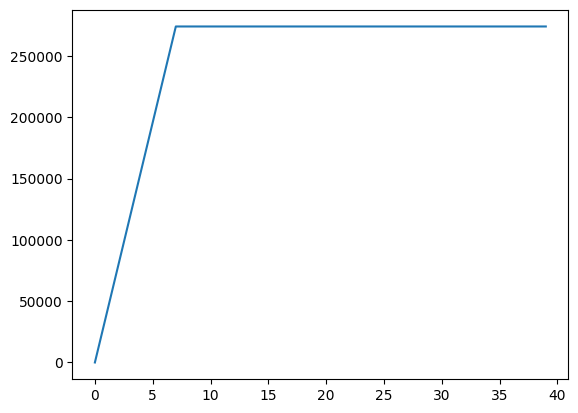

In [1]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import LinearProblem, assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
from dolfinx           import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem       import Constant, dirichletbc, Function, FunctionSpace,form,locate_dofs_topological
from dolfinx.io        import XDMFFile, gmshio
from dolfinx.mesh      import locate_entities,locate_entities_boundary,meshtags
from ufl               import SpatialCoordinate, TestFunction, TrialFunction, dx, grad, inner, Measure, dot, FacetNormal
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py          import PETSc
from mpi4py            import MPI

# import own functions
from brake_disc_functions import *

# calculate how long time the simulation it is 
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 1
mesh_max = 15
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc. 
angular_r = 3590
v_vehicle = 160 
c_acc = 1

# calling local functions to get all parameters
dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c,k,t_brake,S_total \
                = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)

print('1: Total tims is ', round(sum(dt),2), 's')
print('2: Total numb steps is ', num_steps)
plt.plot(P)

## 2: Mesh

In [2]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)  
mesh_filename2 = "m-{}".format(mesh_name)  

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(mesh_filename1, MPI.COMM_WORLD, 0, gdim=3)

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist.")
    mesh_brake_disc(mesh_min, mesh_max,mesh_filename2)
    domain, cell_markers, facet_markers = gmshio.read_from_msh(mesh_filename1, MPI.COMM_WORLD, 0, gdim=3)

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.FunctionSpace(domain, ('CG', 1))

# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs = [])
    return problem.solve()
    
# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = FunctionSpace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init,V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 50) )
bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V)
np.set_printoptions(threshold=np.inf)

import meshio
mesh1= meshio.read(mesh_filename1)
total_elements = sum( len(cells.data) for cells in mesh1.cells )

The file 'm-1-15.msh' exists, start creat now:
Info    : Reading 'm-1-15.msh'...
Info    : 168 entities
Info    : 4281 nodes
Info    : 14875 elements
Info    : Done reading 'm-1-15.msh'



## 3: Setup 


In [3]:
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition

x_co, y_co = get_rub_coordinate()

common_indices3,facet_markers3,sorted_indices3 = target_facets(domain,x_co,y_co,S_rub_circle)
      
facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 


## 4: Variational equation


In [4]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init,V)
t = 0
xdmf.write_function(uh, t)

#u = ufl.TrialFunction(V)
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (rho*c)/dt[0]*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200) \
- ( inner(f,v) *dx + (rho*c)/dt[0] * inner(u_n, v) * dx +  h * Tm * v *ds(200) +  radiation * (Tm**4)* v *ds(200) )


for i in list(range(1,19)):
     F +=  - k * dot( grad(u)* v, n_vector) *ds(10*i) - inner(g[0], v) *ds(10*i)

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert (converged)


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl
pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)
renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            #clim=[0, max(uh.x.array)])
                            clim=[0,  200])

2024-05-01 19:39:41.425 (   4.505s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:39:41.448 (   4.528s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:39:41.465 (   4.545s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0109563 (tol = 1e-10) r (rel) = 2.79087e-06(tol = 1e-06)
2024-05-01 19:39:41.469 (   4.552s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:39:41.488 (   4.568s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 5.00293e-08 (tol = 1e-10) r (rel) = 1.27438e-11(tol = 1e-06)
2024-05-01 19:39:41.488 (   4.568s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 3 iterations and 12 linear solver iterations.


## 5: Solution


In [5]:

T_array = [(0, [Ti for _ in range( len(u.x.array))] )]
total_degree = 0

for i in range(num_steps):
    t += dt[i] 
 
    x_co, y_co = rub_rotation (x_co, y_co, angular_r)   # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step
    
    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/t_brake),1) )+ " %. ")
    sys.stdout.flush()
    
    common_indices3,facet_markers3,sorted_indices3 = target_facets(domain,x_co,y_co,S_rub_circle)      
    facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
    ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 

    F = (rho*c)/dt[i]*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200) \
    - ( inner(f,v) *dx + (rho*c)/dt[i] * inner(u_n, v) * dx +  h * 25* v *ds(200) +  radiation * (25**4)* v *ds(200) )

    for j in list(range(1,19)):
         F +=  - k * dot( grad(u)* v, n_vector) *ds(10*j) - inner(g[i], v) *ds(10*j)

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6
    
    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write('1: Completion is '  + str(round (100*(t/t_brake),1) )+ " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array
    
    T_array.append( (t, u.x.array.copy() ) )
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    #warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()
    
plotter.close() 
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)
save_t_T(csv_name,T_array)

1: Rotation has applied for 3590 degree. 2: Current time is 0.6 s. 3: Completion is 1.3 %. 

2024-05-01 19:39:44.636 (   7.717s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:44.637 (   7.717s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:44.637 (   7.717s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-05-01 19:39:44.637 (   7.717s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:44.637 (   7.717s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:44.637 (   7.717s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-05-01 19:39:44.637 (   7.718s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:44.640 (   7.720s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:44.640 (   7.720s) [mai

1: Completion is 1.3 %. 

2024-05-01 19:39:46.866 (   9.946s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:46.866 (   9.946s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:46.866 (   9.947s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:46.866 (   9.947s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:46.868 (   9.949s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:46.873 (   9.953s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:39:46.893 (   9.973s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:39:46.928 (  10.008s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 7180 degree. 2: Current time is 1.3 s. 3: Completion is 2.7 %. 

2024-05-01 19:39:47.192 (  10.273s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:47.193 (  10.273s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:47.193 (  10.273s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-05-01 19:39:47.193 (  10.273s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:47.194 (  10.274s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:47.194 (  10.274s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-05-01 19:39:47.194 (  10.274s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:47.194 (  10.274s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-01 19:39:47.194 (  10.274s) [mai

1: Rotation has applied for 10770 degree. 2: Current time is 2.0 s. 3: Completion is 4.0 %. 

2024-05-01 19:39:49.277 (  12.357s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:49.277 (  12.357s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:49.278 (  12.358s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:49.278 (  12.358s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:49.280 (  12.360s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:49.289 (  12.370s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:39:49.307 (  12.388s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:39:49.338 (  12.418s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 14360 degree. 2: Current time is 2.6 s. 3: Completion is 5.4 %. 

2024-05-01 19:39:51.562 (  14.643s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:51.563 (  14.643s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:51.563 (  14.644s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:51.564 (  14.644s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:51.566 (  14.646s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:51.571 (  14.651s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:39:51.588 (  14.668s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:39:51.616 (  14.696s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 17950 degree. 2: Current time is 3.3 s. 3: Completion is 6.8 %. 

2024-05-01 19:39:53.913 (  16.994s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:53.913 (  16.994s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:53.914 (  16.994s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:53.914 (  16.994s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:53.916 (  16.996s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:53.917 (  17.001s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:39:53.940 (  17.020s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:39:53.965 (  17.045s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 21540 degree. 2: Current time is 4.0 s. 3: Completion is 8.2 %. 

2024-05-01 19:39:56.170 (  19.250s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:56.170 (  19.250s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:56.170 (  19.251s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:56.170 (  19.251s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:56.172 (  19.253s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:56.177 (  19.258s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:39:56.194 (  19.275s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:39:56.217 (  19.298s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 25130 degree. 2: Current time is 4.7 s. 3: Completion is 9.7 %. 

2024-05-01 19:39:58.464 (  21.545s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:58.464 (  21.545s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:58.465 (  21.545s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:58.465 (  21.545s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:39:58.467 (  21.548s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:39:58.473 (  21.554s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:39:58.488 (  21.568s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:39:58.515 (  21.596s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 28720 degree. 2: Current time is 5.5 s. 3: Completion is 11.1 %. 

2024-05-01 19:40:00.712 (  23.793s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:00.713 (  23.793s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:00.714 (  23.794s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:00.714 (  23.794s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:00.716 (  23.796s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:00.721 (  23.802s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:00.735 (  23.815s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:00.767 (  23.847s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 32310 degree. 2: Current time is 6.2 s. 3: Completion is 12.6 %. 

2024-05-01 19:40:02.618 (  25.956s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:02.878 (  25.958s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:02.878 (  25.959s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:02.878 (  25.959s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:02.885 (  25.965s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:02.894 (  25.974s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:02.909 (  25.989s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:02.939 (  26.019s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 35900 degree. 2: Current time is 6.9 s. 3: Completion is 14.1 %. 

2024-05-01 19:40:05.189 (  28.274s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:05.195 (  28.276s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:05.196 (  28.276s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:05.196 (  28.276s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:05.198 (  28.278s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:05.204 (  28.284s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:05.221 (  28.302s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:05.245 (  28.325s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 39490 degree. 2: Current time is 7.7 s. 3: Completion is 15.7 %. 

2024-05-01 19:40:07.375 (  30.456s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:07.375 (  30.456s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:07.376 (  30.456s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:07.376 (  30.456s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:07.378 (  30.458s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:07.383 (  30.464s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:07.404 (  30.484s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:07.428 (  30.508s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 43080 degree. 2: Current time is 8.4 s. 3: Completion is 17.2 %. 

2024-05-01 19:40:09.670 (  32.750s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:09.670 (  32.750s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:09.670 (  32.751s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:09.670 (  32.751s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:09.672 (  32.753s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:09.678 (  32.758s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:09.692 (  32.772s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:09.718 (  32.799s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 46670 degree. 2: Current time is 9.2 s. 3: Completion is 18.8 %. 

2024-05-01 19:40:11.973 (  35.064s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:11.984 (  35.064s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:11.985 (  35.065s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:11.985 (  35.065s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:11.986 (  35.067s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:11.997 (  35.077s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:12.015 (  35.096s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:12.046 (  35.126s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 50260 degree. 2: Current time is 10.0 s. 3: Completion is 20.5 %. 

2024-05-01 19:40:14.189 (  37.271s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:14.192 (  37.272s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:14.192 (  37.273s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:14.192 (  37.273s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:14.194 (  37.275s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:14.200 (  37.280s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:14.217 (  37.297s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:14.247 (  37.328s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 53850 degree. 2: Current time is 10.8 s. 3: Completion is 22.1 %. 

2024-05-01 19:40:16.457 (  39.538s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:16.458 (  39.539s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:16.459 (  39.539s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:16.459 (  39.539s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:16.461 (  39.541s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:16.463 (  39.544s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:16.483 (  39.563s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:16.510 (  39.591s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 57440 degree. 2: Current time is 11.7 s. 3: Completion is 23.8 %. 

2024-05-01 19:40:18.701 (  41.782s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:18.702 (  41.782s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:18.702 (  41.783s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:18.702 (  41.783s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:18.704 (  41.785s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:18.707 (  41.789s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:18.724 (  41.804s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:18.755 (  41.836s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 61030 degree. 2: Current time is 12.5 s. 3: Completion is 25.6 %. 

2024-05-01 19:40:20.937 (  44.018s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:20.938 (  44.018s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:20.938 (  44.019s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:20.938 (  44.019s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:20.940 (  44.021s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:20.946 (  44.026s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:20.961 (  44.041s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:20.994 (  44.077s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 64620 degree. 2: Current time is 13.4 s. 3: Completion is 27.4 %. 

2024-05-01 19:40:23.201 (  46.281s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:23.204 (  46.284s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:23.205 (  46.285s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:23.205 (  46.285s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:23.207 (  46.287s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:23.213 (  46.293s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:23.237 (  46.317s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:23.264 (  46.344s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 68210 degree. 2: Current time is 14.3 s. 3: Completion is 29.2 %. 

2024-05-01 19:40:25.485 (  48.567s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:25.487 (  48.567s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:25.488 (  48.568s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:25.488 (  48.568s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:25.489 (  48.570s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:25.495 (  48.575s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:25.513 (  48.593s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:25.541 (  48.621s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 71800 degree. 2: Current time is 15.2 s. 3: Completion is 31.0 %. 

2024-05-01 19:40:27.759 (  50.839s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:27.759 (  50.839s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:27.760 (  50.840s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:27.760 (  50.840s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:27.762 (  50.842s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:27.767 (  50.848s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:27.785 (  50.865s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:27.808 (  50.889s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 75390 degree. 2: Current time is 16.2 s. 3: Completion is 33.0 %. 

2024-05-01 19:40:30.027 (  53.107s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:30.027 (  53.107s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:30.028 (  53.108s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:30.028 (  53.108s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:30.030 (  53.110s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:30.036 (  53.116s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:30.056 (  53.136s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:30.083 (  53.164s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 78980 degree. 2: Current time is 17.1 s. 3: Completion is 34.9 %. 

2024-05-01 19:40:32.305 (  55.385s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:32.305 (  55.386s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:32.309 (  55.389s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:32.309 (  55.390s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:32.311 (  55.391s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:32.317 (  55.397s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:32.333 (  55.414s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:32.359 (  55.439s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 82570 degree. 2: Current time is 18.1 s. 3: Completion is 37.0 %. 

2024-05-01 19:40:34.560 (  57.640s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:34.561 (  57.641s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:34.562 (  57.642s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:34.562 (  57.642s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:34.564 (  57.644s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:34.566 (  57.647s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:34.585 (  57.665s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:34.608 (  57.688s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 86160 degree. 2: Current time is 19.1 s. 3: Completion is 39.1 %. 

2024-05-01 19:40:36.798 (  59.882s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:36.809 (  59.889s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:36.809 (  59.890s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:36.810 (  59.890s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:36.812 (  59.892s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:36.817 (  59.897s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:36.832 (  59.912s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:36.855 (  59.935s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 89750 degree. 2: Current time is 20.2 s. 3: Completion is 41.2 %. 

2024-05-01 19:40:39.006 (  62.086s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:39.008 (  62.088s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:39.008 (  62.089s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:39.008 (  62.089s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:39.011 (  62.092s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:39.017 (  62.097s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:39.041 (  62.121s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:39.062 (  62.142s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 93340 degree. 2: Current time is 21.3 s. 3: Completion is 43.5 %. 

2024-05-01 19:40:41.297 (  64.378s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:41.301 (  64.381s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:41.301 (  64.382s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:41.302 (  64.382s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:41.305 (  64.385s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:41.309 (  64.390s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:41.323 (  64.404s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:41.349 (  64.429s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 96930 degree. 2: Current time is 22.5 s. 3: Completion is 45.8 %. 

2024-05-01 19:40:43.569 (  66.649s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:43.569 (  66.650s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:43.571 (  66.651s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:43.571 (  66.651s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:43.573 (  66.653s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:43.579 (  66.659s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:43.593 (  66.673s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:43.619 (  66.700s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 100520 degree. 2: Current time is 23.7 s. 3: Completion is 48.3 %. 

2024-05-01 19:40:45.903 (  68.983s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:45.903 (  68.983s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:45.903 (  68.984s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:45.903 (  68.984s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:45.905 (  68.986s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:45.912 (  68.993s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:45.934 (  69.015s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:45.960 (  69.041s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 104110 degree. 2: Current time is 24.9 s. 3: Completion is 50.8 %. 

2024-05-01 19:40:48.097 (  71.177s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:48.097 (  71.177s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:48.099 (  71.180s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:48.099 (  71.180s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:48.101 (  71.182s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:48.105 (  71.187s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:48.129 (  71.209s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:48.153 (  71.234s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 107700 degree. 2: Current time is 26.2 s. 3: Completion is 53.5 %. 

2024-05-01 19:40:50.312 (  73.393s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:50.313 (  73.393s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:50.313 (  73.394s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:50.313 (  73.394s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:50.316 (  73.396s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:50.317 (  73.401s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:50.341 (  73.422s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:50.365 (  73.446s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 111290 degree. 2: Current time is 27.6 s. 3: Completion is 56.4 %. 

2024-05-01 19:40:52.487 (  75.567s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:52.487 (  75.567s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:52.488 (  75.568s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:52.488 (  75.568s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:52.489 (  75.570s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:52.495 (  75.576s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:52.510 (  75.591s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:52.537 (  75.618s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 114880 degree. 2: Current time is 29.1 s. 3: Completion is 59.4 %. 

2024-05-01 19:40:54.729 (  77.809s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:54.729 (  77.809s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:54.729 (  77.810s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:54.729 (  77.810s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:54.732 (  77.812s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:54.737 (  77.819s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:54.753 (  77.833s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:54.778 (  77.859s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 118470 degree. 2: Current time is 30.7 s. 3: Completion is 62.7 %. 

2024-05-01 19:40:56.994 (  80.077s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:56.997 (  80.078s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:57.000 (  80.080s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:57.000 (  80.080s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:57.002 (  80.082s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:57.008 (  80.088s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:57.029 (  80.109s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:57.055 (  80.135s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 122060 degree. 2: Current time is 32.4 s. 3: Completion is 66.2 %. 

2024-05-01 19:40:59.178 (  82.258s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:59.178 (  82.259s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:59.179 (  82.259s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:59.179 (  82.259s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:40:59.181 (  82.261s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:40:59.186 (  82.267s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:40:59.199 (  82.280s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:40:59.231 (  82.312s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 125650 degree. 2: Current time is 34.4 s. 3: Completion is 70.1 %. 

2024-05-01 19:41:01.452 (  84.532s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:01.452 (  84.532s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:01.453 (  84.533s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:01.453 (  84.533s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:01.454 (  84.534s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:01.460 (  84.540s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:41:01.476 (  84.556s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:41:01.500 (  84.581s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 129240 degree. 2: Current time is 36.5 s. 3: Completion is 74.6 %. 

2024-05-01 19:41:03.697 (  86.778s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:03.700 (  86.780s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:03.701 (  86.781s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:03.701 (  86.781s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:03.702 (  86.782s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:03.705 (  86.786s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:41:03.724 (  86.804s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:41:03.750 (  86.831s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 132830 degree. 2: Current time is 39.1 s. 3: Completion is 79.8 %. 

2024-05-01 19:41:05.966 (  89.047s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:05.967 (  89.047s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:05.967 (  89.048s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:05.967 (  89.048s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:05.969 (  89.050s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:05.975 (  89.055s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:41:05.992 (  89.072s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:41:06.017 (  89.098s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 136420 degree. 2: Current time is 42.3 s. 3: Completion is 86.3 %. 

2024-05-01 19:41:08.188 (  91.268s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:08.188 (  91.268s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:08.188 (  91.269s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:08.189 (  91.269s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:08.191 (  91.271s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:08.196 (  91.276s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:41:08.212 (  91.292s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:41:08.236 (  91.317s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 140010 degree. 2: Current time is 47.0 s. 3: Completion is 96.0 %. 

2024-05-01 19:41:10.393 (  93.473s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:10.393 (  93.473s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:10.393 (  93.474s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:10.393 (  93.474s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:10.396 (  93.477s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:10.403 (  93.484s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:41:10.418 (  93.498s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:41:10.444 (  93.524s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 143600 degree. 2: Current time is 63.3 s. 3: Completion is 129.1 %. 

2024-05-01 19:41:12.665 (  95.746s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:12.668 (  95.748s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:12.668 (  95.749s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:12.668 (  95.749s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:12.671 (  95.752s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:12.673 (  95.759s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:41:12.695 (  95.775s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:41:12.722 (  95.802s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Completion is 129.1 %. 

2024-05-01 19:41:14.977 (  98.057s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:14.977 (  98.057s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:14.977 (  98.058s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:14.977 (  98.058s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-01 19:41:14.980 (  98.061s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-01 19:41:14.982 (  98.063s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-01 19:41:15.000 (  98.080s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-01 19:41:15.027 (  98.107s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system


t and T have been successfully saved as Result_T-s-40-d-3590-m-1-15-c-1-e-14875.csv


# 6: Post process

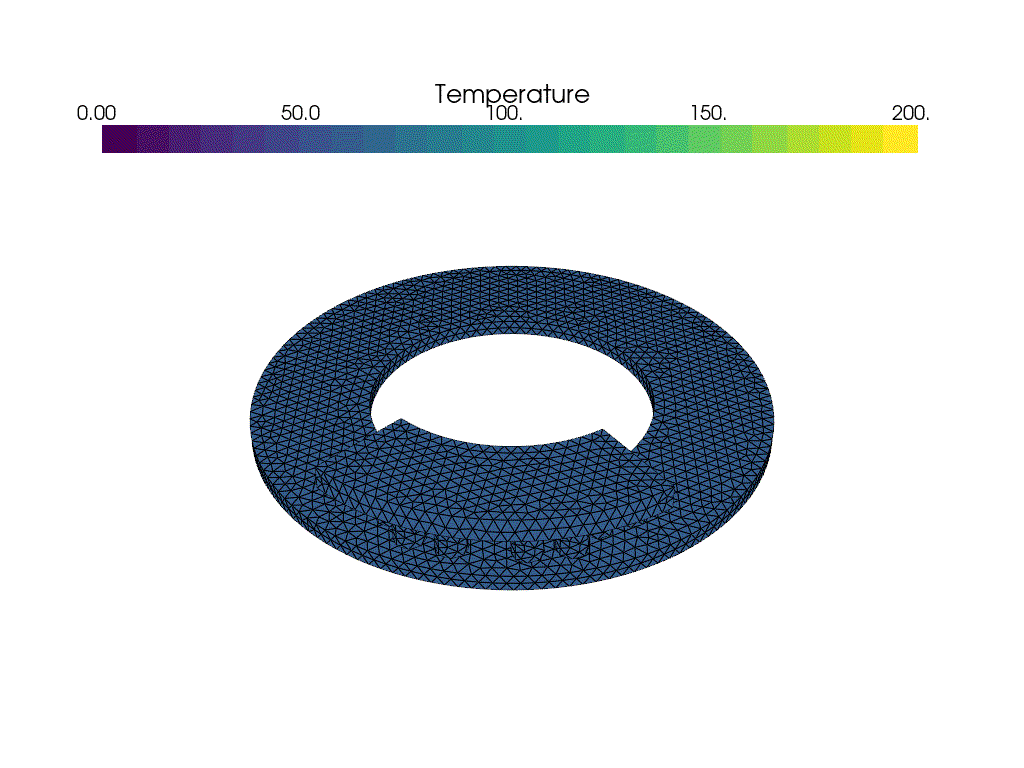

1: Start at: 2024-05-01 19:39:36
2: End at 2024-05-01 19:41:15
3: Simulation time is 0 hours 2 minutes
1: First time step dt is  0.6485 s
2: Convection heat transfer coefficient is 7.75e-05  W/mm2 K
3: Radiation is  3.6e-13  W/mm2 K-4
4: Each rotation degree is  3590  per time step or  10.0  circle
5: The first rotation degree is  15664.3
6: The mid rotation degree is  15664.3
7: The last rotation degree is  15664.3
9: Total contact area of 18 rubbing element is 199.9 cm2
10: The mesh element size is between  1 - 15 mm

Move files successfully


In [6]:
# Display the GIF
from IPython.display import display, Image
display( Image(gif_name) )

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)
with open(txt_name, "w") as file:
   original_print = print
   print = lambda *args, **kwargs: original_print(*args, **kwargs, file=file)
    
   print("1: Start at:", formatted_start_time)
   print('2: End at', formatted_end_time)
    
   if elapsed_time1 >= 60:
      min = elapsed_time1/60
      hours = min/60
      print("3: Simulation time is",round(hours), 'hours', round(min),'minutes')
   else:
      print("3: Simulation time is",elapsed_time1, 'second')

   print('1: First time step dt is ', round(dt[0],5),'s')
   r_disc = 0.25

   print('2: Convection heat transfer coefficient is',h, ' W/mm2 K')
   print('3: Radiation is ', round(radiation,14), ' W/mm2 K-4')
   print('4: Each rotation degree is ', round(angular_r,1), ' per time step', 'or ', round(angular_r/360,1),' circle')
   print('5: The first rotation degree is ', round(v_angular[0] * r_disc * dt[0] *1000, 1) )
   print('6: The mid rotation degree is ', round(v_angular[ round(num_steps/2) ] * r_disc * dt[ round(len(dt)/2) ] *1000, 1) )
   print('7: The last rotation degree is ', round(v_angular[num_steps-1] * r_disc * dt[-1] *1000, 1) )
   print('9: Total contact area of 18 rubbing element is', round(S_total/100,1), 'cm2')
   print('10: The mesh element size is between ',mesh_min, '-',mesh_max, 'mm' )
   #print('11: Total elements number is ',total_elements )    

print = original_print 
with open(txt_name, "r") as file1:
   print( file1.read() )

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Practice/Concise"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
files_to_move = [
                 gif_name,
                 h5_name,
                 xdmf_name,
                 txt_name,
                 csv_name
                           ]
# Move each file to the destination directory
for filename in files_to_move:
    source_file_path = os.path.join(source_dir, filename)
    destination_file_path = os.path.join(destination_dir, filename)
    shutil.move(source_file_path, destination_file_path)
print('Move files successfully')

Total nodes extracted: 1123
Number of nodes with z-coordinate 20.0: 1123


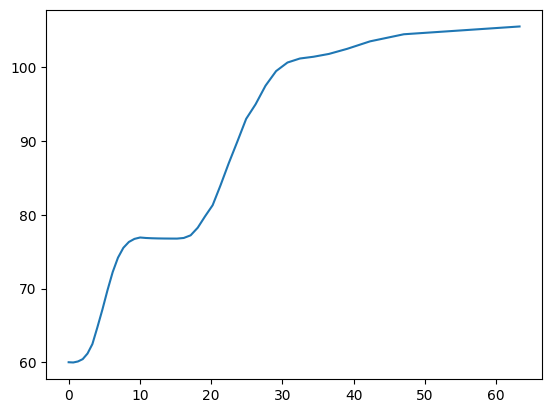

In [7]:
## get t and temperature T form T_array matrix
t = []
T = []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

## get nodes which only in friction surface
filename = 'm-1-15.msh'
nodes,node_tag = read_msh_file(filename)
print("Total nodes extracted:", len(nodes))  # Check the total number of nodes extracted
nodes_z_20 = filter_nodes_by_z(nodes, 20.0)
print("Number of nodes with z-coordinate 20.0:", len(nodes_z_20))

## get T_all with only friction surface
T_friction = []
T_all = []
for i in range(len(T)):
    T_friction = []
    for tag in node_tag:
       T_friction.append(T[i][tag+1])
    T_all.append(T_friction)
    
## get T_ave and T_max in friciton surface
T_ave = []
T_max = []
for i in range(len(T_all)):
    T_max.append( max(T_all[i]) )
    T_ave.append( sum(T_all[i]) / len(T_all[i]) )
    
plt.plot(t,T_ave)

In [8]:
from brake_disc_functions import *
filename = 'm-1-15.msh'
read_msh_file(filename)
nodes = []
nodes_c = []
closest_coordinate = []
node_tag = []
reading_nodes = False
with open(filename, 'r') as f:
        for line in f:
            if line.startswith('$Nodes'):
                reading_nodes = True             
                continue
            elif line.startswith('$EndNodes'):
                reading_nodes = False             
                break
            elif reading_nodes:
                parts = line.split()         
                if len(parts) == 1:  # This line contains only node tag
                    node_tag.append ( int(parts[0]) )
                elif len(parts) == 3:  # This line contains node coordinates
                    x = float(parts[0])
                    y = float(parts[1])
                    z = float(parts[2])
                    nodes_c.append((x, y, z))
for i in range(len(node_tag)):
        nodes.append( (node_tag[i], nodes_c[i])  )

A1_fin, A2_fin, A3_fin = got_T_check_location([247.5, 0])
Three_points = [A1_fin, A2_fin, A3_fin]
for target in  Three_points:
    A_point = target
    coordinates = nodes_c
    distances = [np.sqrt((x - A_point[0])**2 + (y - A_point[1])**2 
                         + (z - A_point[2])**2) for x, y, z in coordinates]
    closest_index = np.argmin(distances)
    closest_coordinate.append(  coordinates[closest_index] )

# Print the closest coordinate
print("Closest coordinate is \n",
      tuple(round(coord, 2) for coord in closest_coordinate[0]),
     "\n", tuple(round(coord, 2) for coord in closest_coordinate[1]),
     "\n", tuple(round(coord, 2) for coord in closest_coordinate[2]),
     "\nPlease open the xdmf file in paraview, and find the labels for above three nodes and input as",
     "\nT_3_labels = [label1, label2, label3]")

A1 location is  (247.5, 0, 19) 
A2 location is  (-123.75, 214.34, 19) 
A3 location is  (-123.75, -214.34, 19)
Closest coordinate is 
 (250.51, 5.23, 20.0) 
 (-125.0, 212.89, 20.0) 
 (-117.41, -215.69, 20.0) 
Please open the xdmf file in paraview, and find the labels for above three nodes and input as 
T_3_labels = [label1, label2, label3]


In [9]:
lables = [2201, 1590, 260]

[0, 0.648503263517273, 1.3057044270206541, 1.9719614611291334, 2.6476575118177346, 3.3332034455631105, 4.029040734576085, 4.735644739280471, 5.4535284568943405, 6.183246819515096, 6.925401643314991, 7.680647353397868, 8.449697637997607, 9.23333322297225, 10.032411005641805, 10.84787484963141, 11.680768424684054, 12.532250584712354, 13.403613924151813, 14.296307352204796, 15.21196379933983, 16.15243455424347, 17.119832274017295, 18.116585496443037, 19.145508639273846, 20.209893208027506, 21.313628603729708, 22.461365136536138, 23.6587387043866, 24.912688124727683, 26.23191627591743, 27.627583135607303, 29.11439017825336, 30.712362792479947, 32.44996615543815, 34.37000210284425, 36.542022914858464, 39.09273076214179, 42.300139297171775, 47.04302296622066, 63.28064832607423]


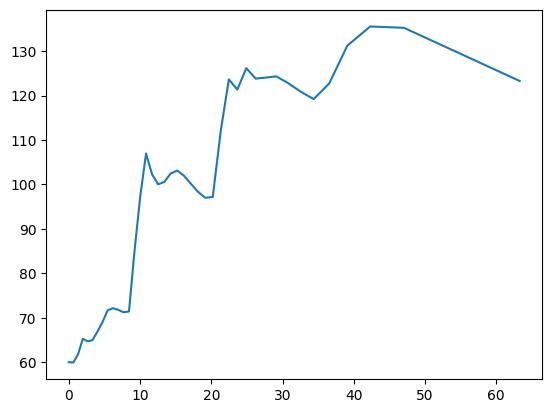

In [10]:
t = []
T = []
for value in T_array:
    t.append(value[0])
    T.append(value[1])
print(t)

T_3_ave = []
for i in range(len(T)):
    T_3_all =  T[i][ lables[0] ] + T[i][ lables[1] ] + T[i][ lables[2] ]   
    T_3_ave.append ( T_3_all / 3 )

plt.plot(t,T_3_ave)
     